Analysis of Statistical Frequency of Characters and Words

Features Computed:

1. Average Token Length: The average length of the tokens in each document.
2. Entropy: Measures the unpredictability of the token distribution using Shannon entropy.

To check whether the  feature importance scores are consistent between K-fold cross-validation and a single train-test split, confirming the relative importance of average_token_length and entropy


In [ ]:
#Libraies
import pandas as pd
import ast
from math import log2


#Loading the dataframe
input_df = pd.read_csv('SMRD.csv', encoding='utf-8')



# Convert string representation of tokens to a list of tokenized words
input_df['tokens'] = input_df['tokens'].str.strip('[]').str.split(', ').apply(lambda x: [token.strip('\'"') for token in x])


# Define functions to compute features

def average_token_length(tokens):
    return sum(len(token) for token in tokens) / len(tokens)


def compute_entropy(tokens):
    freq_dist = pd.Series(tokens).value_counts(normalize=True)
    return -sum(p * log2(p) for p in freq_dist)

# Create new DataFrame to store features
features_df = pd.DataFrame()
features_df['file_name'] = input_df['file_name']
features_df['average_token_length'] = input_df['tokens'].apply(average_token_length)


features_df['entropy'] = input_df['tokens'].apply(compute_entropy)


features_df['labels'] = input_df['label']

# Save the features DataFrame to a new CSV file
features_df.to_csv('features2.csv', index=False)

print(features_df)



                file_name  average_token_length    entropy  labels
0             file371.sql             10.923913   8.526285       1
1             file1803.md              5.376609   7.732721       1
2            CHANGELOG.md              5.220746   7.499278       1
3              file121.py              7.088296   7.556815       1
4               file3.Rmd              4.916359   8.456456       1
..                    ...                   ...        ...     ...
994             file81.md              4.642321   8.528687       0
995           file155.pdf              3.416089  12.869539       0
996            file45.3mf              3.061003  14.715014       0
997  file95-checkpoint.md              6.179054   7.464660       0
998  file47-checkpoint.md              5.511628   5.713658       0

[999 rows x 4 columns]


In [ ]:
import pandas as pd

# Load features from CSV
features_df = pd.read_csv('features2.csv')


## Approach 1  - K fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# Prepare your features and labels
X = features_df.drop(columns=['file_name', 'labels'])
y = features_df['labels']

# Initialize RandomForest and SVM classifiers
rf_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC()

# 5-Fold Cross-validation for RandomForest
rf_scores = cross_val_score(rf_clf, X, y, cv=5, scoring='accuracy')
print(f"RandomForest 5-Fold Cross-Validation Scores: {rf_scores}")
print(f"RandomForest Average Score: {rf_scores.mean()}")

# 5-Fold Cross-validation for SVM
svm_scores = cross_val_score(svm_clf, X, y, cv=5, scoring='accuracy')
print(f"SVM 5-Fold Cross-Validation Scores: {svm_scores}")
print(f"SVM Average Score: {svm_scores.mean()}")


RandomForest 5-Fold Cross-Validation Scores: [0.96       0.96       0.955      0.95       0.93467337]
RandomForest Average Score: 0.9519346733668342
SVM 5-Fold Cross-Validation Scores: [0.955      0.94       0.94       0.945      0.92964824]
SVM Average Score: 0.941929648241206


## Average feature importance across folds

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, random_state=42, shuffle=True)
feature_importances = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf_clf.fit(X_train, y_train)
    feature_importances.append(rf_clf.feature_importances_)

# Average feature importances
avg_importance = np.mean(feature_importances, axis=0)

# Create a DataFrame for the averaged importances
avg_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Average Importance': avg_importance
})

# Sort the DataFrame by the importances
avg_importance_df = avg_importance_df.sort_values(by='Average Importance', ascending=False)

print("Average Feature Importances Across Folds:")
print(avg_importance_df)


Average Feature Importances Across Folds:
                Feature  Average Importance
0  average_token_length            0.575648
1               entropy            0.424352


The average token length have high feature importance

### Approach 2- Train test split

In [ ]:
# Split the data into features and target variable
X = features_df.drop(columns=['file_name', 'labels'])
y = features_df['labels']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Support vector machine

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train, y_train)

# Predictions and Accuracy for SVM
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.2f}")


SVM Accuracy: 0.96


## Random forest classifier

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the features dataset
features_df = pd.read_csv('features2.csv')



In [ ]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True, max_depth=10, min_samples_split=10)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_split=10, oob_score=True,
                       random_state=42)

In [ ]:
# Predictions on the test set
rf_predictions = rf_model.predict(X_test)

# Accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

# Classification report for a detailed performance analysis
print(classification_report(y_test, rf_predictions))

# Out-of-Bag Score for potential overfitting insights
print(f"OOB Score: {rf_model.oob_score_:.2f}")


Random Forest Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       101
           1       0.96      0.99      0.98        99

    accuracy                           0.97       200
   macro avg       0.98      0.98      0.97       200
weighted avg       0.98      0.97      0.97       200

OOB Score: 0.95


### Feature importance

In [ ]:
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_mapping = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_mapping.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")


average_token_length: 0.5777
entropy: 0.4223


The feature importances obtained from both the train-test split and K-fold cross-validation methods are quite similar:

For the train-test split method:

average_token_length: 0.5777
entropy: 0.4223

For the K-fold cross-validation method:

average_token_length: 0.575648
entropy: 0.424352
This similarity suggests a couple of important things:

Stability: The feature importances are stable across different partitions of the data. This lends more confidence to the generalizability of your RandomForest model.

Consistency: The similar importance metrics imply that these features consistently contribute to the model's decision-making process, regardless of the data subset they are trained on.

In practical terms, it would seem that both average_token_length and entropy are significant features for the model. The slight differences in importances are likely due to random fluctuations or sampling error, and they are minor enough that they don't warrant concern.



## Distribution of features

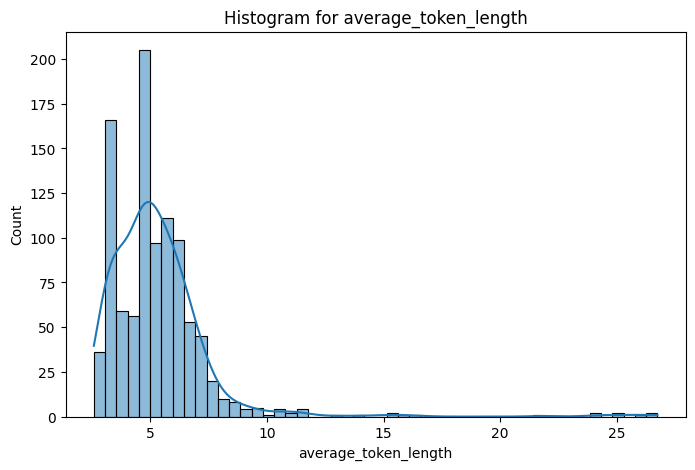

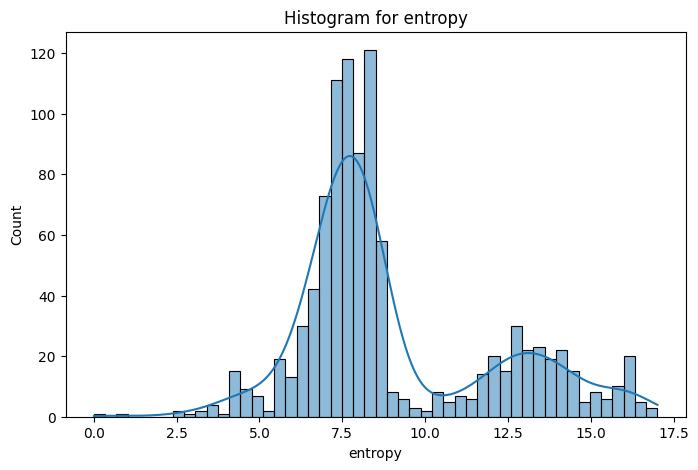

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['average_token_length',   'entropy']

for feature in features:
    plt.figure(figsize=(8, 5))
    sns.histplot(features_df[feature], bins=50, kde=True)
    plt.title(f'Histogram for {feature}')
    plt.show()


### Correlation heatmap

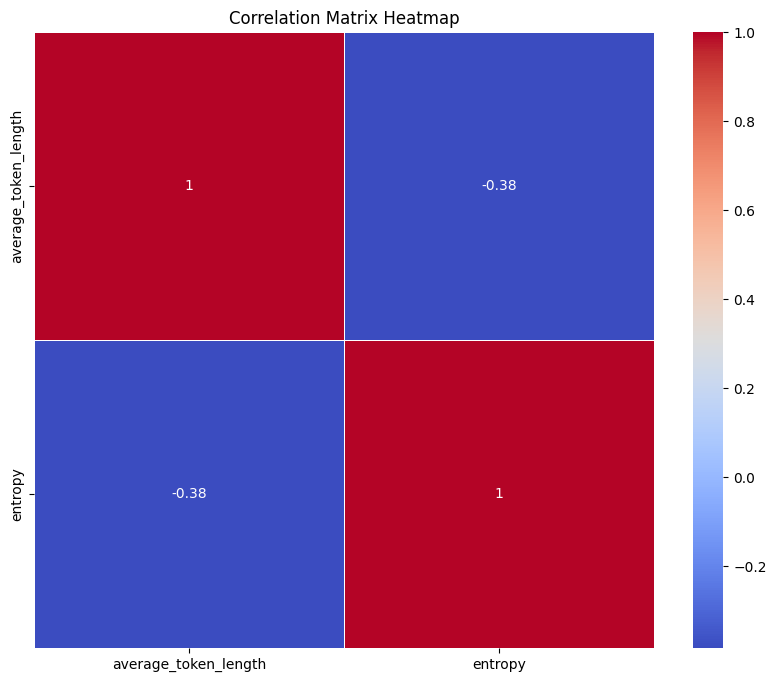

In [ ]:
correlation_matrix = features_df[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


### Statistics

In [ ]:
import pandas as pd

# Read your data
df = pd.read_csv('features2.csv')
# Drop the file_name column
df = df.drop(columns=['file_name'])
# Central Tendency
mean_values = df.mean()
median_values = df.median()
mode_values = df.mode().iloc[0]  # `mode` returns a dataframe, so we take the first row

# Spread
variance_values = df.var()
std_dev_values = df.std()
range_values = df.max() - df.min()
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR_values = Q3 - Q1

# Shape
skewness_values = df.skew()
kurtosis_values = df.kurtosis()

# Combine the statistics into a DataFrame
stats_df = pd.DataFrame({
    'Mean': mean_values,
    'Median': median_values,
    'Mode': mode_values,
    'Variance': variance_values,
    'Std Dev': std_dev_values,
    'Range': range_values,
    'Q1': Q1,
    'Q3': Q3,
    'IQR': IQR_values,
    'Skewness': skewness_values,
    'Kurtosis': kurtosis_values
})

print(stats_df)


                          Mean    Median      Mode  Variance   Std Dev  \
average_token_length  5.315445  4.886398  4.620192  5.994029  2.448271   
entropy               9.004880  8.019002  4.424731  8.859503  2.976492   
labels                0.522523  1.000000  1.000000  0.249743  0.499743   

                          Range        Q1         Q3       IQR  Skewness  \
average_token_length  24.169830  3.799574   6.053323  2.253749  4.744801   
entropy               17.011614  7.222224  10.816926  3.594702  0.876432   
labels                 1.000000  0.000000   1.000000  1.000000 -0.090317   

                       Kurtosis  
average_token_length  33.990958  
entropy                0.050124  
labels                -1.995842  


The statistics suggest that the average_token_length and entropy features are differently distributed. The average_token_length has a mean of about 5.32 but is positively skewed, indicating some tokens are significantly longer and pull the mean upwards. The high variance and standard deviation reinforce this. On the other hand, the entropy feature has a mean of about 9 and is less skewed, with a more uniform distribution as suggested by its lower standard deviation.

### Conclusion


The feature importance scores are consistent between K-fold cross-validation and a single train-test split, confirming the relative importance of average_token_length and entropy. Given the slight variation in feature importance across different K-folds, you can be more confident that these features are genuinely influential and not artifacts of a particular data split.

In summary, the model's strong performance across both validation methods and the consistent feature importance scores add confidence to its robustness and its ability to generalize well to new data.

In terms of feature importance, both average_token_length and entropy seem to be relevant, but average_token_length appears to be slightly more influential in the Random Forest model's decision-making process, based on its higher feature importance score. This suggests that the length of tokens may play a more critical role in classification than entropy, although both are significant features.




